# Time frequency analysis of UKGEOS borehole data
This tutorial is a complete guide to using [distpy](https://github.com/Schlumberger/distpy) on a public dataset. The dataset we will use is not from Distributed Acoustic Sensing (DAS), partly because there is not currently a suitable real-time DAS repository and partly so that the principles can be illustrated on a scale of dataset that is readily downloadable on a stand-alone device like a laptop.

The data will come from the [UKGEOS Glasgow Observatory](https://www.ukgeos.ac.uk/glasgow/seismic-monitoring#downloads) where there are 5 broadband 3C receivers in a vertical array. We will take only the in-line component as this is the one most similar to the information provided by DAS. 

## Strain-rate at low frequency
It has been established that the response of borehole seismic tools and DAS are equivalent if we consider the in-line derivative of particle velocity from a geophone and the strain-rate from DAS. Specifically:

$ \frac{\partial v_z}{\partial z} = \frac{\partial \epsilon_z}{\partial t} $

For a field data example you can look at our [First Break](https://www.earthdoc.org/content/journals/0.3997/1365-2397.35.4.87841) article from 2017. So to give us a flavour of DAS-style data we will take the 5 geophones and difference them to get 4 DAS-equivalent strain-rate measurements.

The Guralp broadband receivers have good [low frequency response](https://www.guralp.com/documents/DAS-RAD-0001.pdf) and the low frequency response of the DAS cable is something that has received a lot of interest in recent years (e.g.[Gin and Roy, 2017](https://pubs.geoscienceworld.org/tle/article-abstract/36/12/975/522822/hydraulic-fracture-geometry-characterization-using) or [Williams et al., 2019](https://onepetro.org/conference-paper/URTEC-2019-184-MS)). We will, therefore concentrate on extracting that low frequency response and plotting it in a useful way.

## The tutorial
At the end of this tutorial you will have
1. Installed __distpy__ and verify the installation
2. Used python's FTP features to download data from a public site, in particular 1 day of data from the UKGEOS Glasgow Observatory
3. Created a custom ingester for MiniSEED data using `obspy`
4. Applied your first __distpy__ signal processig chain: Processed particle velocity to something resembling strain-rate, stacked to a single trace, recovered both RMS of the full spectrum and approximated the sub-Hz low frequency signal.
5. Converted the real-time ready __distpy__ output [WITSML](http://docs.energistics.org/) into `numpy` arrays for easier generation of `matplotlib` results.
6. Extended that analysis with further __distpy__ directed-graphs applied to the output from the initial processing.
7. Produced some example summary plots

Thie processing space and config directory are assumed to be in the `c:/NotBackedUp/ukgeos/` directory. You can run the tutorial in a different location provided you update the config files to reflect that.

## Step 1: Install distpy and verify the installation
The latest __distpy__ is available for installation using the standard Python `pip` installer, so you should be able to just type

`pip install distpy`

into a terminal window and have the package and any necessary dependencies install. If you don't already have [`obspy`](https://github.com/obspy/obspy) then you will need to install that package separately.

Once everything is installed you can run the cell below.

In [42]:
import distpy

print(distpy.__version__)

1.16.0


The version should be `1.16.0` or higher. If you have __distpy__ installed but out of date then try `pip install --upgrade distpy'.

The next cell contains all the imports we will need for ingesting and processing the data. Errors or warnings when executing this cell will highlight any missing packages in your Python installation. They are all available via the `pip install` approach.

In [43]:
import os
import json
import numpy
import distpy.controllers.parallel_strainrate_processing
import distpy.ingesters.parallel_ingest_witsml
from datetime import datetime
from ftplib import FTP

# obspy can be installed using:
#   pip install obspy
#
# https://docs.obspy.org/packages/obspy.io.mseed.html
# NOTE:
#     obspy.io.mseed
#     copyright:   The ObsPy Development Team (devs@obspy.org) & Chad Trabant
#     license:     GNU Lesser General Public License, Version 3 (https://www.gnu.org/copyleft/lesser.html)
import obspy


An eample of the output when the `obspy` package is missing:
```
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<ipython-input-2-dced92c86c5c> in <module>
     16 #     copyright:   The ObsPy Development Team (devs@obspy.org) & Chad Trabant
     17 #     license:     GNU Lesser General Public License, Version 3 (https://www.gnu.org/copyleft/lesser.html)
---> 18 import obspy

ModuleNotFoundError: No module named 'obspy'
```

## Step 2: Using Python's FTP features
In keeping with the [__distpy__ philosophy](https://github.com/Schlumberger/distpy/wiki/Basic-Principles-of-DAS-Interpretation-using-dispty) the function below takes a dictionary for all variables and a destination directory.

The function is specific to the BGS file archive, where the [UKGEOS Glasgow Observatory](https://www.ukgeos.ac.uk/glasgow/seismic-monitoring#downloads) data is stored. The filenames are constructed according to the BGS naming convention.

In [44]:
'''
  recover_bgs_data : recover data from BGS mini-seed archive
                     ftp_config : a dictionary containing the JSON description of the data to be read
                     destination : file path where the data will be stored
'''
def recover_bgs_data(ftp_config, destination):
    # Navigate to my scratch area
    if not os.path.exists(destination):
        os.makedirs(destination)

    os.chdir(destination)
    local_filenames =[]
    for year in ftp_config['years']:
        for day in ftp_config['days']:
            for component in ftp_config['components']:
                for receiver in ftp_config['receivers']:
                    filename = ftp_config['network'] + '.' + ftp_config['site'] + '.' + receiver + '.' + component + '.' + year + '.' + day
                    print(filename)
                    local_filenames.append(filename)

    # The simple 'restart' mechanism skips files that were downloaded in a previous attempt
    read=False
    for filename in local_filenames:
        if not os.path.exists(filename):
            read=True
    if read==False:
        print('Files detected in ',destination,' will not be re-fetched')

    # GRAB A FILE FROM FTP...
    # ftp://seiswav.bgs.ac.uk/2019/GGERF/CNZ.D/GB.GGERF.00.CNZ.D.2019.140
    if (read==True):
        ifile=0
        ftp = FTP(ftp_config['ftp_site'])
        for year in ftp_config['years']:
            for day in ftp_config['days']:
                for component in ftp_config['components']:
                    filelocation = year + '/' + ftp_config['site'] + '/' + component
                    print(filelocation)                    
                    ftp.login()
                    ftp.cwd(filelocation)
                    for receiver in ftp_config['receivers']:
                        filename = local_filenames[ifile]
                        ifile+=1
                        if not os.path.exists(filename):
                            print('copying ',filename)
                            # https://stackoverflow.com/questions/4696413/ftp-retrbinary-help-python
                            with open(filename, 'wb') as f:
                                def callback(data):
                                    f.write(data)
                                ftp.retrbinary('RETR %s' % filename, callback)
                        else:
                            print('not copying ',filename,' as it already exists in ',destination)
                    ftp.quit()
    
    return local_filenames


## Step 3: A custom ingester for MiniSEED
The [miniSEED format](https://ds.iris.edu/ds/nodes/dmc/data/formats/miniseed/) is used quite a bit in earthquake seismology. 
There is no MiniSEED ingester provided in the __distpy__ library. The code below is written in the style of __distpy__ and can be used as a template for any custom ingesters you find you need, should you come across a non-standard DAS file format. For more information on writing ingesters and contributing them to __distpy__ see the [Dev Tutorial](https://github.com/Schlumberger/distpy/wiki/Dev-Tutorial-:-Extending-distpy-with-new-ingesters) on the topic. 

Note, if you are writing ingesters for inclusion in __distpy__, that the example below is based on `obspy` which is licensed under the [GNU Lesser General Public License, Version 3](https://www.gnu.org/copyleft/lesser.html), whereas for inclusion in __distpy__ an ingester must conform to the [MIT License](https://github.com/Schlumberger/distpy/blob/master/LICENSE) or similar.


In [45]:
'''
   ingest_mseed : uses the obspy MSEED reader to ingest data. All receivers are placed in the same
                  file so that the resulting data blocks are (x,t) similar to fibre data
'''
def ingest_mseed(rec_md, rec_file, dirout):
    xaxis = numpy.asarray(rec_md)
    if not os.path.exists(dirout):
        os.makedirs(dirout)
    numpy.save(os.path.join(dirout,'measured_depth.npy'),xaxis)

    # test one file to determine PRF
    data = obspy.read(rec_file[0])
    prf = int(data[0].stats['sampling_rate'])
    total_samples = int(data[0].stats['npts'])
    unixtime = int(data[0].stats['starttime'].timestamp)

    data =[]
    for fname in rec_file:
        data.append(obspy.read(fname))
        prf2 = int(data[-1][0].stats['sampling_rate'])
        if not prf2==prf:
            print('Some receivers are at ',prf,' Hz, others at ',prf2)
        total_samples = int(data[-1][0].stats['npts'])
        unixtime = int(data[-1][0].stats['starttime'].timestamp)
        print(fname,str(prf),str(total_samples),str(unixtime))

    data_block = numpy.zeros((len(rec_md),prf))
    for ii in range(0,total_samples-prf,prf):
        filename = os.path.join(dirout,str(unixtime)+'.npy')
        # Only write the file if it does not exist already.
        if not os.path.exists(filename):
            for jj in range(len(rec_md)):
                data_block[jj,:]=data[jj][0].data[ii:ii+prf]
            numpy.save(os.path.join(dirout,str(unixtime)+'.npy'),data_block)
        unixtime+=1
    return prf


### Basic I/O for JSON files
The following pair of functions support basic read and write for Python dictionaries via JSON. In __dispty__ all processing flow and configuration information are separated from the execution code via transferrable JSON objects. 

In some projects, such as this tutorial example, you will want to work partly inside and partly outside the __distpy__ framework. Using these functions allows you to keep the consistent style.

In [46]:
'''
 json_read : reads from a json file into a dictionary. Useful for configuration
             metadata
'''
def json_read(filename):
    with open(filename) as json_file:
        return json.load(json_file)

def json_write(dictJSON,filename):
    with open(filename, 'w') as json_file:
        json.dump(dictJSON, json_file)

## Step 4: Execute a signal processing chain using distpy
The execution pipeline includes the following steps:
1. Reading the JSON configuration for the FTP request `ftpConfigFile` and updating it with user specified information (day & year)
2. Read the JSON configuration for the MiniSEED ingestion `mseedConfigFile` and locate the directory where the downloaded data will be hosted and then processed
3. Download data from the FTP server
4. Ingest the miniSEED data for processing by __distpy__
5. Update the processing file to use the pulse repetition frequency (prf) of the downloaded data
6. Execute the processing with __distpy__, based on the JSON configuration in `processingConfigFile`
7. Ingest the WITSML format results from __distpy__ for further proecssing, based on the configuration in `configWITSMLIngest`

In [47]:
def processing_chain(day,year,ftpConfigFile,mseedConfigFile,processingConfigFile,configWITSMLIngest):
    
    # STEP 1: Read the JSON configuration for the FTP request
    ftp_config = json_read(ftpConfigFile)
    ftp_config['days']=[day]
    ftp_config['years']=[year]
    
    # STEP 2: Read the JSON configuration for the miniSEED ingestion
    ingestMSEED = json_read(mseedConfigFile)
    MY_SCRATCH = os.path.join(ingestMSEED['out_drive'],ingestMSEED['project'],ingestMSEED['data'])
    dirout = os.path.join(ingestMSEED['out_drive'],ingestMSEED['project'],ingestMSEED['results'])
    
    # STEP 3: Recover data from the BGS archive
    local_fnames = recover_bgs_data(ftp_config,MY_SCRATCH)
    
    # STEP 4: MiniSEED INGEST
    prf = ingest_mseed(ftp_config['measured_depth'], local_fnames, dirout)

    # STEP 5: Update the processing file to use the pulse repetition frequency (prf) of the downloaded data
    processingDict = json_read(processingConfigFile)
    processingDict['prf'] = prf
    json_write(processingDict, processingConfigFile)
    
    # STEP 6: Continue processing with distpy
    distpy.controllers.parallel_strainrate_processing.main(processingConfigFile)
    
    # STEP 7: Ingest the WITSML for further processing with distpy, numpy and matplotlib
    distpy.ingesters.parallel_ingest_witsml.main(configWITSMLIngest)


## Step 5: Execute the processing pipeline and convert the WITSML back to numpy array format
In the code below you can set the day number and year (refer to the [UKGEOS site](https://www.ukgeos.ac.uk/glasgow/seismic-monitoring#downloads) for a full description of available data). In general there is data from October 2019 onwards.

The code could be changed to accommodate a list of days, we suggest during testing to only process one day's data at a time. Usefully, however, the __distpy__ system will provide the signal processing across all available days, so when running subsequent times, you can pick other days to append your dataset and the final graphs will include all previously processed data. 

Once processed down to the RMS (broadband root-mean-square) and VLF (very low frequency), you don't need to keep the raw data you downloaded, or the ingested version. So when you're pushed for space, you can process one day at a time, and keep only those processed results. The original data is available to redownload at a later date if you design a better processing chain.

In [48]:
day = "051"
year = "2020"


# CONFIGs - this directory will need to be changed to reflect your system
CONFIG_DIR = "C:/NotBackedUp/ukgeos/config"

ftpConfigFile = os.path.join(CONFIG_DIR,'ftpBGS.json')
mseedConfigFile = os.path.join(CONFIG_DIR,'ingestMSEED.json')
processingConfigFile = os.path.join(CONFIG_DIR,'seismic2vlfConfig.json')
witsmlConfigFile = os.path.join(CONFIG_DIR,'ingestWITSMLConfig.json')

processing_chain(day,year,ftpConfigFile,mseedConfigFile,processingConfigFile,witsmlConfigFile)

GB.GGERF.04.CNZ.D.2020.051
GB.GGERF.03.CNZ.D.2020.051
GB.GGERF.02.CNZ.D.2020.051
GB.GGERF.01.CNZ.D.2020.051
GB.GGERF.00.CNZ.D.2020.051
Files detected in  C:/NotBackedUp\ukgeos\raw_data  will not be re-fetched
GB.GGERF.04.CNZ.D.2020.051 500 4922000 1582156800
GB.GGERF.03.CNZ.D.2020.051 500 4922000 1582156800
GB.GGERF.02.CNZ.D.2020.051 500 4922000 1582156800
GB.GGERF.01.CNZ.D.2020.051 500 4922000 1582156800
GB.GGERF.00.CNZ.D.2020.051 500 4922000 1582156800
{'document': 0, 'name': 'Approximate very low frequency results', 'description': 'Creates an estimate of the very low frequency response and the RMS of the data overall.', 'command_list': [{'name': 'approx_vlf', 'uid': 1, 'in_uid': 0}, {'name': 'fft', 'uid': 2, 'in_uid': 0}, {'name': 'rms_from_fft', 'uid': 3, 'in_uid': 2, 'low_freq': 0, 'high_freq': -1}, {'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf'}], 'BOX_SIZE': 500}
C:/NotBackedUp\ukgeos\inge

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156815', 'datestring': '2020-02-20T00:00:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156815.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156816.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156816', 'datestring': '2020-02-20T00:00:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156830', 'datestring': '2020-02-20T00:00:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156830.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156831.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156831', 'datestring': '2020-02-20T00:00:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156846', 'datestring': '2020-02-20T00:00:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156846.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156847.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156847', 'datestring': '2020-02-20T00:00:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156872', 'datestring': '2020-02-20T00:01:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156872.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156873.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156873', 'datestring': '2020-02-20T00:01:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156894', 'datestring': '2020-02-20T00:01:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156894.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156895.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156895', 'datestring': '2020-02-20T00:01:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156913', 'datestring': '2020-02-20T00:01:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156913.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156914.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156914', 'datestring': '2020-02-20T00:01:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156929', 'datestring': '2020-02-20T00:02:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156929.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156930.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156930', 'datestring': '2020-02-20T00:02:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156944', 'datestring': '2020-02-20T00:02:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156944.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156945.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156945', 'datestring': '2020-02-20T00:02:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156963', 'datestring': '2020-02-20T00:02:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156963.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156964.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156964', 'datestring': '2020-02-20T00:02:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156987', 'datestring': '2020-02-20T00:03:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582156987.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582156988.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582156988', 'datestring': '2020-02-20T00:03:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582157010.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157011.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157011', 'datestring': '2020-02-20T00:03:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157011.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157012.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157025', 'datestring': '2020-02-20T00:03:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812E8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157025.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157026.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157026', 'datestring': '2020-02-20T00:03:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157042', 'datestring': '2020-02-20T00:04:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81470>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157042.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157043.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157043', 'datestring': '2020-02-20T00:04:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157071', 'datestring': '2020-02-20T00:04:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157071.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157072.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157072', 'datestring': '2020-02-20T00:04:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582157086.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157087.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157087', 'datestring': '2020-02-20T00:04:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157087.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157088.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157115', 'datestring': '2020-02-20T00:05:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81470>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157115.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157116.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157116', 'datestring': '2020-02-20T00:05:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157135', 'datestring': '2020-02-20T00:05:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157135.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157136.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157136', 'datestring': '2020-02-20T00:05:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157164', 'datestring': '2020-02-20T00:06:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988BAC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157164.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157165.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157165', 'datestring': '2020-02-20T00:06:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157190', 'datestring': '2020-02-20T00:06:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157190.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157191.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157191', 'datestring': '2020-02-20T00:06:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582157203.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157204.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157204', 'datestring': '2020-02-20T00:06:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157204.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157205.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157231', 'datestring': '2020-02-20T00:07:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81710>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157231.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157232.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157232', 'datestring': '2020-02-20T00:07:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157246', 'datestring': '2020-02-20T00:07:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157246.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157247.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157247', 'datestring': '2020-02-20T00:07:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157273', 'datestring': '2020-02-20T00:07:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157273.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157274.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157274', 'datestring': '2020-02-20T00:07:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157296', 'datestring': '2020-02-20T00:08:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157296.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157297.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157297', 'datestring': '2020-02-20T00:08:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157310', 'datestring': '2020-02-20T00:08:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157310.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157311.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157311', 'datestring': '2020-02-20T00:08:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157325', 'datestring': '2020-02-20T00:08:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157325.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157326.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157326', 'datestring': '2020-02-20T00:08:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157354', 'datestring': '2020-02-20T00:09:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81CC0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157354.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157355.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157355', 'datestring': '2020-02-20T00:09:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157380', 'datestring': '2020-02-20T00:09:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157380.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157381.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157381', 'datestring': '2020-02-20T00:09:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157396', 'datestring': '2020-02-20T00:09:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157396.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157397.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157397', 'datestring': '2020-02-20T00:09:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157420', 'datestring': '2020-02-20T00:10:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819E8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157420.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157421.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157421', 'datestring': '2020-02-20T00:10:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157434', 'datestring': '2020-02-20T00:10:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157434.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157435.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157435', 'datestring': '2020-02-20T00:10:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157458', 'datestring': '2020-02-20T00:10:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157458.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157459.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157459', 'datestring': '2020-02-20T00:10:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157481', 'datestring': '2020-02-20T00:11:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157481.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157482.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157482', 'datestring': '2020-02-20T00:11:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157505', 'datestring': '2020-02-20T00:11:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157505.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157506.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157506', 'datestring': '2020-02-20T00:11:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157531', 'datestring': '2020-02-20T00:12:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157531.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157532.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157532', 'datestring': '2020-02-20T00:12:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157547', 'datestring': '2020-02-20T00:12:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157547.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157548.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157548', 'datestring': '2020-02-20T00:12:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157563', 'datestring': '2020-02-20T00:12:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157563.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157564.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157564', 'datestring': '2020-02-20T00:12:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157579', 'datestring': '2020-02-20T00:12:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157579.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157580.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157580', 'datestring': '2020-02-20T00:13:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157594', 'datestring': '2020-02-20T00:13:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157594.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157595.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157595', 'datestring': '2020-02-20T00:13:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157610', 'datestring': '2020-02-20T00:13:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157610.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157611.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157611', 'datestring': '2020-02-20T00:13:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157636', 'datestring': '2020-02-20T00:13:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157636.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157637.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157637', 'datestring': '2020-02-20T00:13:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157650', 'datestring': '2020-02-20T00:14:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906358>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157650.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157651.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157651', 'datestring': '2020-02-20T00:14:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157667', 'datestring': '2020-02-20T00:14:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906278>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157667.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157668.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157668', 'datestring': '2020-02-20T00:14:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157690', 'datestring': '2020-02-20T00:14:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157690.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157691.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157691', 'datestring': '2020-02-20T00:14:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157704', 'datestring': '2020-02-20T00:15:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906358>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157704.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157705.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157705', 'datestring': '2020-02-20T00:15:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157719', 'datestring': '2020-02-20T00:15:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157719.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157720.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157720', 'datestring': '2020-02-20T00:15:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157749', 'datestring': '2020-02-20T00:15:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157749.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157750.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157750', 'datestring': '2020-02-20T00:15:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157766', 'datestring': '2020-02-20T00:16:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157766.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157767.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157767', 'datestring': '2020-02-20T00:16:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157790', 'datestring': '2020-02-20T00:16:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157790.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157791.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157791', 'datestring': '2020-02-20T00:16:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157810', 'datestring': '2020-02-20T00:16:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157810.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157811.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157811', 'datestring': '2020-02-20T00:16:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157825', 'datestring': '2020-02-20T00:17:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157825.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157826.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157826', 'datestring': '2020-02-20T00:17:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157839', 'datestring': '2020-02-20T00:17:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157839.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157840.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157840', 'datestring': '2020-02-20T00:17:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157856', 'datestring': '2020-02-20T00:17:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906438>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157856.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157857.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157857', 'datestring': '2020-02-20T00:17:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157871', 'datestring': '2020-02-20T00:17:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157871.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157872.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157872', 'datestring': '2020-02-20T00:17:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157888', 'datestring': '2020-02-20T00:18:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A810B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157888.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157889.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157889', 'datestring': '2020-02-20T00:18:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157906', 'datestring': '2020-02-20T00:18:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157906.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157907.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157907', 'datestring': '2020-02-20T00:18:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157921', 'datestring': '2020-02-20T00:18:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157921.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157922.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157922', 'datestring': '2020-02-20T00:18:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582157943.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157944.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157944', 'datestring': '2020-02-20T00:19:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157944.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157945.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157957', 'datestring': '2020-02-20T00:19:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157957.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157958.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157958', 'datestring': '2020-02-20T00:19:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157975', 'datestring': '2020-02-20T00:19:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81470>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157975.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157976.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157976', 'datestring': '2020-02-20T00:19:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157989', 'datestring': '2020-02-20T00:19:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582157989.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582157990.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582157990', 'datestring': '2020-02-20T00:19:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158004', 'datestring': '2020-02-20T00:20:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158004.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158005.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158005', 'datestring': '2020-02-20T00:20:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158019', 'datestring': '2020-02-20T00:20:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158019.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158020.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158020', 'datestring': '2020-02-20T00:20:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158033', 'datestring': '2020-02-20T00:20:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158033.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158034.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158034', 'datestring': '2020-02-20T00:20:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158049', 'datestring': '2020-02-20T00:20:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158049.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158050.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158050', 'datestring': '2020-02-20T00:20:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158075', 'datestring': '2020-02-20T00:21:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158075.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158076.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158076', 'datestring': '2020-02-20T00:21:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158102', 'datestring': '2020-02-20T00:21:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158102.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158103.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158103', 'datestring': '2020-02-20T00:21:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158127', 'datestring': '2020-02-20T00:22:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158127.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158128.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158128', 'datestring': '2020-02-20T00:22:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582158140.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158141.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158141', 'datestring': '2020-02-20T00:22:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81A90>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158141.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158142.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158156', 'datestring': '2020-02-20T00:22:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158156.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158157.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158157', 'datestring': '2020-02-20T00:22:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158173', 'datestring': '2020-02-20T00:22:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158173.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158174.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158174', 'datestring': '2020-02-20T00:22:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158187', 'datestring': '2020-02-20T00:23:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158187.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158188.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158188', 'datestring': '2020-02-20T00:23:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158201', 'datestring': '2020-02-20T00:23:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158201.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158202.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158202', 'datestring': '2020-02-20T00:23:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158227', 'datestring': '2020-02-20T00:23:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158227.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158228.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158228', 'datestring': '2020-02-20T00:23:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158242', 'datestring': '2020-02-20T00:24:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158242.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158243.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158243', 'datestring': '2020-02-20T00:24:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158258', 'datestring': '2020-02-20T00:24:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158258.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158259.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158259', 'datestring': '2020-02-20T00:24:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158284', 'datestring': '2020-02-20T00:24:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158284.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158285.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158285', 'datestring': '2020-02-20T00:24:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582158298.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158299.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158299', 'datestring': '2020-02-20T00:24:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158299.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158300.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158315', 'datestring': '2020-02-20T00:25:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158315.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158316.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158316', 'datestring': '2020-02-20T00:25:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158332', 'datestring': '2020-02-20T00:25:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158332.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158333.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158333', 'datestring': '2020-02-20T00:25:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158346', 'datestring': '2020-02-20T00:25:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299060B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158346.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158347.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158347', 'datestring': '2020-02-20T00:25:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158360', 'datestring': '2020-02-20T00:26:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158360.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158361.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158361', 'datestring': '2020-02-20T00:26:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158375', 'datestring': '2020-02-20T00:26:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158375.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158376.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158376', 'datestring': '2020-02-20T00:26:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582158398.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158399.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158399', 'datestring': '2020-02-20T00:26:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158399.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158400.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158412', 'datestring': '2020-02-20T00:26:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A810B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158412.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158413.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158413', 'datestring': '2020-02-20T00:26:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158428', 'datestring': '2020-02-20T00:27:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81A90>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158428.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158429.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158429', 'datestring': '2020-02-20T00:27:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158444', 'datestring': '2020-02-20T00:27:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158444.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158445.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158445', 'datestring': '2020-02-20T00:27:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158467', 'datestring': '2020-02-20T00:27:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158467.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158468.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158468', 'datestring': '2020-02-20T00:27:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158481', 'datestring': '2020-02-20T00:28:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299060B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158481.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158482.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158482', 'datestring': '2020-02-20T00:28:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158496', 'datestring': '2020-02-20T00:28:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988B080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158496.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158497.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158497', 'datestring': '2020-02-20T00:28:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158522', 'datestring': '2020-02-20T00:28:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F60>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158522.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158523.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158523', 'datestring': '2020-02-20T00:28:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158536', 'datestring': '2020-02-20T00:28:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158536.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158537.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158537', 'datestring': '2020-02-20T00:28:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582158552.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158553.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158553', 'datestring': '2020-02-20T00:29:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158553.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158554.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158567', 'datestring': '2020-02-20T00:29:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81710>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158567.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158568.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158568', 'datestring': '2020-02-20T00:29:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158590', 'datestring': '2020-02-20T00:29:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158590.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158591.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158591', 'datestring': '2020-02-20T00:29:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158604', 'datestring': '2020-02-20T00:30:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158604.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158605.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158605', 'datestring': '2020-02-20T00:30:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158631', 'datestring': '2020-02-20T00:30:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158631.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158632.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158632', 'datestring': '2020-02-20T00:30:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158652', 'datestring': '2020-02-20T00:30:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819E8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158652.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158653.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158653', 'datestring': '2020-02-20T00:30:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158676', 'datestring': '2020-02-20T00:31:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158676.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158677.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158677', 'datestring': '2020-02-20T00:31:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158701', 'datestring': '2020-02-20T00:31:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158701.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158702.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158702', 'datestring': '2020-02-20T00:31:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158718', 'datestring': '2020-02-20T00:31:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158718.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158719.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158719', 'datestring': '2020-02-20T00:31:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158741', 'datestring': '2020-02-20T00:32:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158741.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158742.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158742', 'datestring': '2020-02-20T00:32:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158759', 'datestring': '2020-02-20T00:32:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158759.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158760.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158760', 'datestring': '2020-02-20T00:32:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158774', 'datestring': '2020-02-20T00:32:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158774.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158775.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158775', 'datestring': '2020-02-20T00:32:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158805', 'datestring': '2020-02-20T00:33:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81A90>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158805.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158806.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158806', 'datestring': '2020-02-20T00:33:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158829', 'datestring': '2020-02-20T00:33:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158829.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158830.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158830', 'datestring': '2020-02-20T00:33:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158843', 'datestring': '2020-02-20T00:34:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158843.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158844.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158844', 'datestring': '2020-02-20T00:34:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158871', 'datestring': '2020-02-20T00:34:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158871.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158872.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158872', 'datestring': '2020-02-20T00:34:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158891', 'datestring': '2020-02-20T00:34:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F60>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158891.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158892.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158892', 'datestring': '2020-02-20T00:34:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582158908.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158909.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158909', 'datestring': '2020-02-20T00:35:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158909.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158910.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158925', 'datestring': '2020-02-20T00:35:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158925.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158926.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158926', 'datestring': '2020-02-20T00:35:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158947', 'datestring': '2020-02-20T00:35:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158947.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158948.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158948', 'datestring': '2020-02-20T00:35:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158961', 'datestring': '2020-02-20T00:36:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158961.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158962.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158962', 'datestring': '2020-02-20T00:36:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158976', 'datestring': '2020-02-20T00:36:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158976.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158977.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158977', 'datestring': '2020-02-20T00:36:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158995', 'datestring': '2020-02-20T00:36:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582158995.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582158996.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582158996', 'datestring': '2020-02-20T00:36:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159023', 'datestring': '2020-02-20T00:37:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159023.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159024.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159024', 'datestring': '2020-02-20T00:37:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159053', 'datestring': '2020-02-20T00:37:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159053.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159054.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159054', 'datestring': '2020-02-20T00:37:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159082', 'datestring': '2020-02-20T00:38:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159082.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159083.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159083', 'datestring': '2020-02-20T00:38:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159106', 'datestring': '2020-02-20T00:38:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159106.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159107.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159107', 'datestring': '2020-02-20T00:38:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159120', 'datestring': '2020-02-20T00:38:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159120.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159121.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159121', 'datestring': '2020-02-20T00:38:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159134', 'datestring': '2020-02-20T00:38:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159134.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159135.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159135', 'datestring': '2020-02-20T00:38:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\ingested_data\1582159150.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159150', 'datestring': '2020-02-20T00:39:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159150.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159151.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159151', 'datestring': '2020-02-20T00:39:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159164', 'datestring': '2020-02-20T00:39:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906C88>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159164.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159165.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159165', 'datestring': '2020-02-20T00:39:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159185', 'datestring': '2020-02-20T00:39:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159185.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159186.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159186', 'datestring': '2020-02-20T00:39:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159204', 'datestring': '2020-02-20T00:40:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159204.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159205.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159205', 'datestring': '2020-02-20T00:40:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159225', 'datestring': '2020-02-20T00:40:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159225.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159226.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159226', 'datestring': '2020-02-20T00:40:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159248', 'datestring': '2020-02-20T00:40:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159248.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159249.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159249', 'datestring': '2020-02-20T00:40:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159264', 'datestring': '2020-02-20T00:41:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159264.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159265.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159265', 'datestring': '2020-02-20T00:41:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159292', 'datestring': '2020-02-20T00:41:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81470>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159292.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159293.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159293', 'datestring': '2020-02-20T00:41:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159309', 'datestring': '2020-02-20T00:41:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159309.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159310.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159310', 'datestring': '2020-02-20T00:41:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159335', 'datestring': '2020-02-20T00:42:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159335.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159336.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159336', 'datestring': '2020-02-20T00:42:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

C:/NotBackedUp\ukgeos\witsml\vlf\1582159353.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159354.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159354', 'datestring': '2020-02-20T00:42:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159354.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159355.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159371', 'datestring': '2020-02-20T00:42:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159371.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159372.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159372', 'datestring': '2020-02-20T00:42:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159385', 'datestring': '2020-02-20T00:43:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159385.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159386.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159386', 'datestring': '2020-02-20T00:43:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159402', 'datestring': '2020-02-20T00:43:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F60>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159402.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159403.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159403', 'datestring': '2020-02-20T00:43:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159416', 'datestring': '2020-02-20T00:43:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159416.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159417.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159417', 'datestring': '2020-02-20T00:43:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159434', 'datestring': '2020-02-20T00:43:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159434.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159435.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159435', 'datestring': '2020-02-20T00:43:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159457', 'datestring': '2020-02-20T00:44:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159457.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159458.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159458', 'datestring': '2020-02-20T00:44:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159482', 'datestring': '2020-02-20T00:44:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159482.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159483.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159483', 'datestring': '2020-02-20T00:44:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159506', 'datestring': '2020-02-20T00:45:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81278>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159506.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159507.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159507', 'datestring': '2020-02-20T00:45:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159523', 'datestring': '2020-02-20T00:45:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299060B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159523.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159524.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159524', 'datestring': '2020-02-20T00:45:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159552', 'datestring': '2020-02-20T00:45:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159552.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159553.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159553', 'datestring': '2020-02-20T00:45:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159568', 'datestring': '2020-02-20T00:46:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159568.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159569.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159569', 'datestring': '2020-02-20T00:46:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

C:/NotBackedUp\ukgeos\witsml\vlf\1582159582.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159583.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159583', 'datestring': '2020-02-20T00:46:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A810B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159583.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159584.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

C:/NotBackedUp\ukgeos\witsml\vlf\1582159599.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159600.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159600', 'datestring': '2020-02-20T00:46:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906B38>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159601.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

C:/NotBackedUp\ukgeos\witsml\vlf\1582159613.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159614.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159614', 'datestring': '2020-02-20T00:46:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159614.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159615.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159632', 'datestring': '2020-02-20T00:47:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159632.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159633.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159633', 'datestring': '2020-02-20T00:47:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159657', 'datestring': '2020-02-20T00:47:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062E8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159657.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159658.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159658', 'datestring': '2020-02-20T00:47:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159674', 'datestring': '2020-02-20T00:47:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299067B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159674.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159675.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159675', 'datestring': '2020-02-20T00:47:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159690', 'datestring': '2020-02-20T00:48:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159690.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159691.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159691', 'datestring': '2020-02-20T00:48:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159721', 'datestring': '2020-02-20T00:48:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A811D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159721.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159722.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159722', 'datestring': '2020-02-20T00:48:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159747', 'datestring': '2020-02-20T00:49:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159747.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159748.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159748', 'datestring': '2020-02-20T00:49:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159764', 'datestring': '2020-02-20T00:49:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81470>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159764.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159765.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159765', 'datestring': '2020-02-20T00:49:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159778', 'datestring': '2020-02-20T00:49:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159778.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159779.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159779', 'datestring': '2020-02-20T00:49:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159805', 'datestring': '2020-02-20T00:50:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159805.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159806.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159806', 'datestring': '2020-02-20T00:50:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159827', 'datestring': '2020-02-20T00:50:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159827.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159828.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159828', 'datestring': '2020-02-20T00:50:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159842', 'datestring': '2020-02-20T00:50:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159842.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159843.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159843', 'datestring': '2020-02-20T00:50:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159861', 'datestring': '2020-02-20T00:51:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159861.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159862.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159862', 'datestring': '2020-02-20T00:51:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159877', 'datestring': '2020-02-20T00:51:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159877.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159878.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159878', 'datestring': '2020-02-20T00:51:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159900', 'datestring': '2020-02-20T00:51:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159900.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159901.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159901', 'datestring': '2020-02-20T00:51:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159917', 'datestring': '2020-02-20T00:51:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159917.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159918.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159918', 'datestring': '2020-02-20T00:51:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582159937.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159938.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159938', 'datestring': '2020-02-20T00:52:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159938.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159939.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159952', 'datestring': '2020-02-20T00:52:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159952.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159953.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159953', 'datestring': '2020-02-20T00:52:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159979', 'datestring': '2020-02-20T00:52:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159979.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159980.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159980', 'datestring': '2020-02-20T00:53:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159997', 'datestring': '2020-02-20T00:53:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906588>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582159997.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582159998.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582159998', 'datestring': '2020-02-20T00:53:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160011', 'datestring': '2020-02-20T00:53:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160011.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160012.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160012', 'datestring': '2020-02-20T00:53:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582160039.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160040.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160040', 'datestring': '2020-02-20T00:54:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160040.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160041.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160055', 'datestring': '2020-02-20T00:54:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160055.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160056.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160056', 'datestring': '2020-02-20T00:54:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582160070.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160071.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160071', 'datestring': '2020-02-20T00:54:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906978>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160071.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160072.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160085', 'datestring': '2020-02-20T00:54:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160085.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160086.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160086', 'datestring': '2020-02-20T00:54:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160108', 'datestring': '2020-02-20T00:55:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906128>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160108.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160109.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160109', 'datestring': '2020-02-20T00:55:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160124', 'datestring': '2020-02-20T00:55:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160124.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160125.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160125', 'datestring': '2020-02-20T00:55:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160142', 'datestring': '2020-02-20T00:55:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160142.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160143.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160143', 'datestring': '2020-02-20T00:55:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160157', 'datestring': '2020-02-20T00:55:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160157.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160158.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160158', 'datestring': '2020-02-20T00:55:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160171', 'datestring': '2020-02-20T00:56:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A817F0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160171.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160172.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160172', 'datestring': '2020-02-20T00:56:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160195', 'datestring': '2020-02-20T00:56:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160195.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160196.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160196', 'datestring': '2020-02-20T00:56:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160224', 'datestring': '2020-02-20T00:57:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160224.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160225.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160225', 'datestring': '2020-02-20T00:57:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160241', 'datestring': '2020-02-20T00:57:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160241.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160242.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160242', 'datestring': '2020-02-20T00:57:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160256', 'datestring': '2020-02-20T00:57:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160256.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160257.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160257', 'datestring': '2020-02-20T00:57:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160271', 'datestring': '2020-02-20T00:57:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160271.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160272.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160272', 'datestring': '2020-02-20T00:57:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160287', 'datestring': '2020-02-20T00:58:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160287.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160288.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160288', 'datestring': '2020-02-20T00:58:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160304', 'datestring': '2020-02-20T00:58:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81278>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160304.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160305.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160305', 'datestring': '2020-02-20T00:58:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160333', 'datestring': '2020-02-20T00:58:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160333.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160334.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160334', 'datestring': '2020-02-20T00:58:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160349', 'datestring': '2020-02-20T00:59:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160349.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160350.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160350', 'datestring': '2020-02-20T00:59:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160364', 'datestring': '2020-02-20T00:59:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160364.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160365.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160365', 'datestring': '2020-02-20T00:59:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160379', 'datestring': '2020-02-20T00:59:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160379.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160380.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160380', 'datestring': '2020-02-20T00:59:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160396', 'datestring': '2020-02-20T00:59:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299061D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160396.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160397.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160397', 'datestring': '2020-02-20T00:59:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160412', 'datestring': '2020-02-20T01:00:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160412.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160413.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160413', 'datestring': '2020-02-20T01:00:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160434', 'datestring': '2020-02-20T01:00:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906438>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160434.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160435.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160435', 'datestring': '2020-02-20T01:00:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582160448.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160449.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160449', 'datestring': '2020-02-20T01:00:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160449.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160450.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160472', 'datestring': '2020-02-20T01:01:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906438>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160472.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160473.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160473', 'datestring': '2020-02-20T01:01:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160486', 'datestring': '2020-02-20T01:01:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160486.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160487.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160487', 'datestring': '2020-02-20T01:01:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160515', 'datestring': '2020-02-20T01:01:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160515.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160516.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160516', 'datestring': '2020-02-20T01:01:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160535', 'datestring': '2020-02-20T01:02:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160535.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160536.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160536', 'datestring': '2020-02-20T01:02:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160557', 'datestring': '2020-02-20T01:02:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160557.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160558.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160558', 'datestring': '2020-02-20T01:02:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160573', 'datestring': '2020-02-20T01:02:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160573.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160574.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160574', 'datestring': '2020-02-20T01:02:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160603', 'datestring': '2020-02-20T01:03:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906B38>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160603.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160604.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160604', 'datestring': '2020-02-20T01:03:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160618', 'datestring': '2020-02-20T01:03:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988BAC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160618.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160619.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160619', 'datestring': '2020-02-20T01:03:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160641', 'datestring': '2020-02-20T01:04:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299063C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160641.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160642.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160642', 'datestring': '2020-02-20T01:04:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160656', 'datestring': '2020-02-20T01:04:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988B400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160656.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160657.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160657', 'datestring': '2020-02-20T01:04:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160671', 'datestring': '2020-02-20T01:04:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160671.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160672.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160672', 'datestring': '2020-02-20T01:04:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160696', 'datestring': '2020-02-20T01:04:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160696.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160697.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160697', 'datestring': '2020-02-20T01:04:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160711', 'datestring': '2020-02-20T01:05:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160711.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160712.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160712', 'datestring': '2020-02-20T01:05:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160727', 'datestring': '2020-02-20T01:05:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160727.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160728.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160728', 'datestring': '2020-02-20T01:05:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160743', 'datestring': '2020-02-20T01:05:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160743.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160744.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160744', 'datestring': '2020-02-20T01:05:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160761', 'datestring': '2020-02-20T01:06:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160761.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160762.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160762', 'datestring': '2020-02-20T01:06:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160776', 'datestring': '2020-02-20T01:06:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160776.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160777.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160777', 'datestring': '2020-02-20T01:06:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582160791.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160792.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160792', 'datestring': '2020-02-20T01:06:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988B400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160792.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160793.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160816', 'datestring': '2020-02-20T01:06:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160816.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160817.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160817', 'datestring': '2020-02-20T01:06:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160842', 'datestring': '2020-02-20T01:07:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160842.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160843.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160843', 'datestring': '2020-02-20T01:07:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160865', 'datestring': '2020-02-20T01:07:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160865.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160866.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160866', 'datestring': '2020-02-20T01:07:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160880', 'datestring': '2020-02-20T01:08:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81278>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160880.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160881.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160881', 'datestring': '2020-02-20T01:08:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160905', 'datestring': '2020-02-20T01:08:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A811D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160905.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160906.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160906', 'datestring': '2020-02-20T01:08:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160927', 'datestring': '2020-02-20T01:08:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160927.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160928.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160928', 'datestring': '2020-02-20T01:08:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160942', 'datestring': '2020-02-20T01:09:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160942.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160943.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160943', 'datestring': '2020-02-20T01:09:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160968', 'datestring': '2020-02-20T01:09:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160968.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160969.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160969', 'datestring': '2020-02-20T01:09:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160985', 'datestring': '2020-02-20T01:09:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582160985.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582160986.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582160986', 'datestring': '2020-02-20T01:09:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161012', 'datestring': '2020-02-20T01:10:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161012.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161013.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161013', 'datestring': '2020-02-20T01:10:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

C:/NotBackedUp\ukgeos\witsml\vlf\1582161036.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161037.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161037', 'datestring': '2020-02-20T01:10:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161037.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161038.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161054', 'datestring': '2020-02-20T01:10:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161054.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161055.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161055', 'datestring': '2020-02-20T01:10:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161069', 'datestring': '2020-02-20T01:11:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161069.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161070.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161070', 'datestring': '2020-02-20T01:11:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161084', 'datestring': '2020-02-20T01:11:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161084.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161085.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161085', 'datestring': '2020-02-20T01:11:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161099', 'datestring': '2020-02-20T01:11:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161099.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161100.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161100', 'datestring': '2020-02-20T01:11:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161115', 'datestring': '2020-02-20T01:11:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062E8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161115.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161116.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161116', 'datestring': '2020-02-20T01:11:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161129', 'datestring': '2020-02-20T01:12:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161129.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161130.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161130', 'datestring': '2020-02-20T01:12:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161155', 'datestring': '2020-02-20T01:12:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161155.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161156.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161156', 'datestring': '2020-02-20T01:12:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161169', 'datestring': '2020-02-20T01:12:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161169.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161170.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161170', 'datestring': '2020-02-20T01:12:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161196', 'datestring': '2020-02-20T01:13:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161196.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161197.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161197', 'datestring': '2020-02-20T01:13:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161219', 'datestring': '2020-02-20T01:13:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161219.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161220.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161220', 'datestring': '2020-02-20T01:13:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161242', 'datestring': '2020-02-20T01:14:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161242.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161243.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161243', 'datestring': '2020-02-20T01:14:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

C:/NotBackedUp\ukgeos\witsml\vlf\1582161257.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161258.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161258', 'datestring': '2020-02-20T01:14:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161258.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161259.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161275', 'datestring': '2020-02-20T01:14:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161275.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161276.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161276', 'datestring': '2020-02-20T01:14:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\ingested_data\1582161301.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161301', 'datestring': '2020-02-20T01:15:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161301.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161302.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161302', 'datestring': '2020-02-20T01:15:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

C:/NotBackedUp\ukgeos\witsml\vlf\1582161315.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161316.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161316', 'datestring': '2020-02-20T01:15:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161316.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161317.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161332', 'datestring': '2020-02-20T01:15:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161332.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161333.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161333', 'datestring': '2020-02-20T01:15:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161350', 'datestring': '2020-02-20T01:15:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161350.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161351.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161351', 'datestring': '2020-02-20T01:15:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

C:/NotBackedUp\ukgeos\ingested_data\1582161364.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161364', 'datestring': '2020-02-20T01:16:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161364.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161365.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161365', 'datestring': '2020-02-20T01:16:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161379', 'datestring': '2020-02-20T01:16:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906978>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161379.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161380.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161380', 'datestring': '2020-02-20T01:16:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161393', 'datestring': '2020-02-20T01:16:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161393.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161394.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161394', 'datestring': '2020-02-20T01:16:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161408', 'datestring': '2020-02-20T01:16:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161408.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161409.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161409', 'datestring': '2020-02-20T01:16:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161438', 'datestring': '2020-02-20T01:17:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161438.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161439.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161439', 'datestring': '2020-02-20T01:17:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161464', 'datestring': '2020-02-20T01:17:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988BB00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161464.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161465.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161465', 'datestring': '2020-02-20T01:17:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161489', 'datestring': '2020-02-20T01:18:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161489.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161490.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161490', 'datestring': '2020-02-20T01:18:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161511', 'datestring': '2020-02-20T01:18:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161511.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161512.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161512', 'datestring': '2020-02-20T01:18:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161525', 'datestring': '2020-02-20T01:18:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161525.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161526.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161526', 'datestring': '2020-02-20T01:18:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161551', 'datestring': '2020-02-20T01:19:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906358>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161551.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161552.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161552', 'datestring': '2020-02-20T01:19:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161576', 'datestring': '2020-02-20T01:19:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161576.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161577.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161577', 'datestring': '2020-02-20T01:19:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161601', 'datestring': '2020-02-20T01:20:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161601.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161602.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161602', 'datestring': '2020-02-20T01:20:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161629', 'datestring': '2020-02-20T01:20:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F60>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161629.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161630.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161630', 'datestring': '2020-02-20T01:20:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161644', 'datestring': '2020-02-20T01:20:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161644.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161645.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161645', 'datestring': '2020-02-20T01:20:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161661', 'datestring': '2020-02-20T01:21:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161661.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161662.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161662', 'datestring': '2020-02-20T01:21:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161676', 'datestring': '2020-02-20T01:21:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161676.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161677.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161677', 'datestring': '2020-02-20T01:21:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161693', 'datestring': '2020-02-20T01:21:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988B400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161693.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161694.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161694', 'datestring': '2020-02-20T01:21:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161708', 'datestring': '2020-02-20T01:21:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161708.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161709.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161709', 'datestring': '2020-02-20T01:21:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582161736.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161737.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161737', 'datestring': '2020-02-20T01:22:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161737.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161738.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161755', 'datestring': '2020-02-20T01:22:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161755.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161756.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161756', 'datestring': '2020-02-20T01:22:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161783', 'datestring': '2020-02-20T01:23:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161783.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161784.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161784', 'datestring': '2020-02-20T01:23:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161806', 'datestring': '2020-02-20T01:23:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161806.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161807.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161807', 'datestring': '2020-02-20T01:23:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161820', 'datestring': '2020-02-20T01:23:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A811D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161820.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161821.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161821', 'datestring': '2020-02-20T01:23:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161843', 'datestring': '2020-02-20T01:24:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161843.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161844.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161844', 'datestring': '2020-02-20T01:24:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161859', 'datestring': '2020-02-20T01:24:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161859.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161860.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161860', 'datestring': '2020-02-20T01:24:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582161885.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161886.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161886', 'datestring': '2020-02-20T01:24:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161886.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161887.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

C:/NotBackedUp\ukgeos\witsml\vlf\1582161911.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161912.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161912', 'datestring': '2020-02-20T01:25:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906D68>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161912.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161913.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161941', 'datestring': '2020-02-20T01:25:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161941.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161942.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161942', 'datestring': '2020-02-20T01:25:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161960', 'datestring': '2020-02-20T01:26:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161960.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161961.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161961', 'datestring': '2020-02-20T01:26:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161974', 'datestring': '2020-02-20T01:26:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161974.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161975.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161975', 'datestring': '2020-02-20T01:26:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161989', 'datestring': '2020-02-20T01:26:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299064A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582161989.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582161990.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582161990', 'datestring': '2020-02-20T01:26:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162019', 'datestring': '2020-02-20T01:26:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162019.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162020.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162020', 'datestring': '2020-02-20T01:27:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162034', 'datestring': '2020-02-20T01:27:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162034.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162035.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162035', 'datestring': '2020-02-20T01:27:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162055', 'datestring': '2020-02-20T01:27:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162055.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162056.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162056', 'datestring': '2020-02-20T01:27:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162073', 'datestring': '2020-02-20T01:27:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162073.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162074.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162074', 'datestring': '2020-02-20T01:27:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582162099.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162100.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162100', 'datestring': '2020-02-20T01:28:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162100.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162101.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162121', 'datestring': '2020-02-20T01:28:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162121.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162122.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162122', 'datestring': '2020-02-20T01:28:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162143', 'datestring': '2020-02-20T01:29:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162143.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162144.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162144', 'datestring': '2020-02-20T01:29:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162169', 'datestring': '2020-02-20T01:29:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162169.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162170.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162170', 'datestring': '2020-02-20T01:29:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162185', 'datestring': '2020-02-20T01:29:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162185.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162186.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162186', 'datestring': '2020-02-20T01:29:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162201', 'datestring': '2020-02-20T01:30:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162201.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162202.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162202', 'datestring': '2020-02-20T01:30:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162226', 'datestring': '2020-02-20T01:30:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E80>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162226.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162227.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162227', 'datestring': '2020-02-20T01:30:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162251', 'datestring': '2020-02-20T01:30:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162251.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162252.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162252', 'datestring': '2020-02-20T01:30:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162275', 'datestring': '2020-02-20T01:31:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162275.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162276.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162276', 'datestring': '2020-02-20T01:31:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162290', 'datestring': '2020-02-20T01:31:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162290.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162291.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162291', 'datestring': '2020-02-20T01:31:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162306', 'datestring': '2020-02-20T01:31:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162306.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162307.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162307', 'datestring': '2020-02-20T01:31:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162321', 'datestring': '2020-02-20T01:32:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162321.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162322.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162322', 'datestring': '2020-02-20T01:32:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582162341.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162342.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162342', 'datestring': '2020-02-20T01:32:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162342.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162343.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162365', 'datestring': '2020-02-20T01:32:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906438>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162365.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162366.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162366', 'datestring': '2020-02-20T01:32:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162382', 'datestring': '2020-02-20T01:33:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162382.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162383.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162383', 'datestring': '2020-02-20T01:33:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162409', 'datestring': '2020-02-20T01:33:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162409.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162410.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162410', 'datestring': '2020-02-20T01:33:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162434', 'datestring': '2020-02-20T01:33:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162434.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162435.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162435', 'datestring': '2020-02-20T01:33:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162449', 'datestring': '2020-02-20T01:34:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F60>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162449.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162450.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162450', 'datestring': '2020-02-20T01:34:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162468', 'datestring': '2020-02-20T01:34:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162468.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162469.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162469', 'datestring': '2020-02-20T01:34:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162484', 'datestring': '2020-02-20T01:34:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F60>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162484.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162485.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162485', 'datestring': '2020-02-20T01:34:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162505', 'datestring': '2020-02-20T01:35:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162505.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162506.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162506', 'datestring': '2020-02-20T01:35:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162519', 'datestring': '2020-02-20T01:35:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299067B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162519.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162520.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162520', 'datestring': '2020-02-20T01:35:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162538', 'datestring': '2020-02-20T01:35:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906B38>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162538.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162539.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162539', 'datestring': '2020-02-20T01:35:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162552', 'datestring': '2020-02-20T01:35:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162552.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162553.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162553', 'datestring': '2020-02-20T01:35:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162568', 'datestring': '2020-02-20T01:36:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162568.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162569.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162569', 'datestring': '2020-02-20T01:36:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

C:/NotBackedUp\ukgeos\ingested_data\1582162584.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162584', 'datestring': '2020-02-20T01:36:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162584.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162585.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162585', 'datestring': '2020-02-20T01:36:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

C:/NotBackedUp\ukgeos\witsml\vlf\1582162604.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162605.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162605', 'datestring': '2020-02-20T01:36:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162605.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162606.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162619', 'datestring': '2020-02-20T01:36:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162619.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162620.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162620', 'datestring': '2020-02-20T01:37:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162641', 'datestring': '2020-02-20T01:37:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162641.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162642.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162642', 'datestring': '2020-02-20T01:37:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162664', 'datestring': '2020-02-20T01:37:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162664.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162665.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162665', 'datestring': '2020-02-20T01:37:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162681', 'datestring': '2020-02-20T01:38:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162681.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162682.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162682', 'datestring': '2020-02-20T01:38:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162700', 'datestring': '2020-02-20T01:38:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DA0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162700.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162701.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162701', 'datestring': '2020-02-20T01:38:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162717', 'datestring': '2020-02-20T01:38:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162717.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162718.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162718', 'datestring': '2020-02-20T01:38:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162742', 'datestring': '2020-02-20T01:39:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162742.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162743.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162743', 'datestring': '2020-02-20T01:39:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162757', 'datestring': '2020-02-20T01:39:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162757.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162758.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162758', 'datestring': '2020-02-20T01:39:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162779', 'datestring': '2020-02-20T01:39:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162779.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162780.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162780', 'datestring': '2020-02-20T01:39:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162806', 'datestring': '2020-02-20T01:40:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162806.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162807.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162807', 'datestring': '2020-02-20T01:40:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162821', 'datestring': '2020-02-20T01:40:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162821.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162822.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162822', 'datestring': '2020-02-20T01:40:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162846', 'datestring': '2020-02-20T01:40:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162846.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162847.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162847', 'datestring': '2020-02-20T01:40:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162874', 'datestring': '2020-02-20T01:41:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162874.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162875.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162875', 'datestring': '2020-02-20T01:41:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162889', 'datestring': '2020-02-20T01:41:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162889.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162890.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162890', 'datestring': '2020-02-20T01:41:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162911', 'datestring': '2020-02-20T01:41:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162911.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162912.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162912', 'datestring': '2020-02-20T01:41:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162927', 'datestring': '2020-02-20T01:42:07+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162927.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162928.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162928', 'datestring': '2020-02-20T01:42:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

C:/NotBackedUp\ukgeos\witsml\vlf\1582162943.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162944.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162944', 'datestring': '2020-02-20T01:42:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162944.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162945.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162960', 'datestring': '2020-02-20T01:42:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162960.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162961.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162961', 'datestring': '2020-02-20T01:42:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162978', 'datestring': '2020-02-20T01:42:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162978.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162979.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162979', 'datestring': '2020-02-20T01:42:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162995', 'datestring': '2020-02-20T01:43:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582162995.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582162996.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582162996', 'datestring': '2020-02-20T01:43:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163015', 'datestring': '2020-02-20T01:43:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163015.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163016.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163016', 'datestring': '2020-02-20T01:43:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163037', 'datestring': '2020-02-20T01:43:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163037.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163038.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163038', 'datestring': '2020-02-20T01:43:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163066', 'datestring': '2020-02-20T01:44:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163066.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163067.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163067', 'datestring': '2020-02-20T01:44:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163093', 'datestring': '2020-02-20T01:44:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163093.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163094.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163094', 'datestring': '2020-02-20T01:44:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163114', 'datestring': '2020-02-20T01:45:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163114.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163115.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163115', 'datestring': '2020-02-20T01:45:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163130', 'datestring': '2020-02-20T01:45:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163130.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163131.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163131', 'datestring': '2020-02-20T01:45:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163152', 'datestring': '2020-02-20T01:45:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163152.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163153.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163153', 'datestring': '2020-02-20T01:45:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163181', 'datestring': '2020-02-20T01:46:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906128>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163181.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163182.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163182', 'datestring': '2020-02-20T01:46:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163196', 'datestring': '2020-02-20T01:46:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DA0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163196.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163197.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163197', 'datestring': '2020-02-20T01:46:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163224', 'datestring': '2020-02-20T01:47:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163224.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163225.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163225', 'datestring': '2020-02-20T01:47:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163245', 'datestring': '2020-02-20T01:47:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163245.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163246.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163246', 'datestring': '2020-02-20T01:47:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163264', 'datestring': '2020-02-20T01:47:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163264.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163265.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163265', 'datestring': '2020-02-20T01:47:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163293', 'datestring': '2020-02-20T01:48:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163293.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163294.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163294', 'datestring': '2020-02-20T01:48:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163314', 'datestring': '2020-02-20T01:48:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299060B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163314.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163315.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163315', 'datestring': '2020-02-20T01:48:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163336', 'datestring': '2020-02-20T01:48:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163336.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163337.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163337', 'datestring': '2020-02-20T01:48:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163362', 'datestring': '2020-02-20T01:49:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163362.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163363.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163363', 'datestring': '2020-02-20T01:49:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163387', 'datestring': '2020-02-20T01:49:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163387.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163388.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163388', 'datestring': '2020-02-20T01:49:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163401', 'datestring': '2020-02-20T01:50:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163401.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163402.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163402', 'datestring': '2020-02-20T01:50:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163424', 'datestring': '2020-02-20T01:50:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163424.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163425.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163425', 'datestring': '2020-02-20T01:50:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163440', 'datestring': '2020-02-20T01:50:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163440.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163441.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163441', 'datestring': '2020-02-20T01:50:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163455', 'datestring': '2020-02-20T01:50:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163455.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163456.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163456', 'datestring': '2020-02-20T01:50:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163474', 'datestring': '2020-02-20T01:51:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163474.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163475.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163475', 'datestring': '2020-02-20T01:51:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163498', 'datestring': '2020-02-20T01:51:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163498.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163499.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163499', 'datestring': '2020-02-20T01:51:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163520', 'datestring': '2020-02-20T01:52:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163520.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163521.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163521', 'datestring': '2020-02-20T01:52:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163535', 'datestring': '2020-02-20T01:52:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163535.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163536.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163536', 'datestring': '2020-02-20T01:52:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163549', 'datestring': '2020-02-20T01:52:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163549.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163550.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163550', 'datestring': '2020-02-20T01:52:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163574', 'datestring': '2020-02-20T01:52:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163574.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163575.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163575', 'datestring': '2020-02-20T01:52:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163595', 'datestring': '2020-02-20T01:53:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163595.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163596.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163596', 'datestring': '2020-02-20T01:53:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163614', 'datestring': '2020-02-20T01:53:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163614.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163615.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163615', 'datestring': '2020-02-20T01:53:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163633', 'datestring': '2020-02-20T01:53:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163633.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163634.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163634', 'datestring': '2020-02-20T01:53:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163657', 'datestring': '2020-02-20T01:54:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163657.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163658.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163658', 'datestring': '2020-02-20T01:54:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163680', 'datestring': '2020-02-20T01:54:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163680.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163681.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163681', 'datestring': '2020-02-20T01:54:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163696', 'datestring': '2020-02-20T01:54:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163696.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163697.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163697', 'datestring': '2020-02-20T01:54:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163721', 'datestring': '2020-02-20T01:55:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163721.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163722.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163722', 'datestring': '2020-02-20T01:55:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163735', 'datestring': '2020-02-20T01:55:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163735.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163736.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163736', 'datestring': '2020-02-20T01:55:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163760', 'datestring': '2020-02-20T01:56:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163760.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163761.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163761', 'datestring': '2020-02-20T01:56:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163776', 'datestring': '2020-02-20T01:56:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163776.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163777.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163777', 'datestring': '2020-02-20T01:56:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163803', 'datestring': '2020-02-20T01:56:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163803.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163804.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163804', 'datestring': '2020-02-20T01:56:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163822', 'datestring': '2020-02-20T01:57:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163822.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163823.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163823', 'datestring': '2020-02-20T01:57:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582163835.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163836.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163836', 'datestring': '2020-02-20T01:57:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163836.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163837.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163859', 'datestring': '2020-02-20T01:57:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163859.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163860.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163860', 'datestring': '2020-02-20T01:57:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163877', 'datestring': '2020-02-20T01:57:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81278>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163877.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163878.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163878', 'datestring': '2020-02-20T01:57:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163903', 'datestring': '2020-02-20T01:58:23+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906588>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163903.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163904.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163904', 'datestring': '2020-02-20T01:58:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163928', 'datestring': '2020-02-20T01:58:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163928.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163929.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163929', 'datestring': '2020-02-20T01:58:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163955', 'datestring': '2020-02-20T01:59:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906588>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163955.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163956.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163956', 'datestring': '2020-02-20T01:59:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163975', 'datestring': '2020-02-20T01:59:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299060B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582163975.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582163976.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582163976', 'datestring': '2020-02-20T01:59:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164001', 'datestring': '2020-02-20T02:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164001.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164002.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164002', 'datestring': '2020-02-20T02:00:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164016', 'datestring': '2020-02-20T02:00:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906550>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164016.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164017.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164017', 'datestring': '2020-02-20T02:00:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164040', 'datestring': '2020-02-20T02:00:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164040.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164041.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164041', 'datestring': '2020-02-20T02:00:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164054', 'datestring': '2020-02-20T02:00:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164054.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164055.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164055', 'datestring': '2020-02-20T02:00:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582164077.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164078.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164078', 'datestring': '2020-02-20T02:01:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DA0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164078.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164079.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

C:/NotBackedUp\ukgeos\ingested_data\1582164092.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164092', 'datestring': '2020-02-20T02:01:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164092.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164093.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164093', 'datestring': '2020-02-20T02:01:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164106', 'datestring': '2020-02-20T02:01:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906B38>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164106.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164107.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164107', 'datestring': '2020-02-20T02:01:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164130', 'datestring': '2020-02-20T02:02:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164130.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164131.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164131', 'datestring': '2020-02-20T02:02:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164151', 'datestring': '2020-02-20T02:02:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164151.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164152.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164152', 'datestring': '2020-02-20T02:02:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164176', 'datestring': '2020-02-20T02:02:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164176.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164177.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164177', 'datestring': '2020-02-20T02:02:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\ingested_data\1582164195.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164195', 'datestring': '2020-02-20T02:03:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164195.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164196.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164196', 'datestring': '2020-02-20T02:03:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164215', 'datestring': '2020-02-20T02:03:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164215.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164216.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164216', 'datestring': '2020-02-20T02:03:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164238', 'datestring': '2020-02-20T02:03:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164238.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164239.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164239', 'datestring': '2020-02-20T02:03:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164266', 'datestring': '2020-02-20T02:04:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988BAC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164266.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164267.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164267', 'datestring': '2020-02-20T02:04:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164283', 'datestring': '2020-02-20T02:04:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164283.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164284.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164284', 'datestring': '2020-02-20T02:04:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164303', 'datestring': '2020-02-20T02:05:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164303.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164304.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164304', 'datestring': '2020-02-20T02:05:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164317', 'datestring': '2020-02-20T02:05:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299061D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164317.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164318.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164318', 'datestring': '2020-02-20T02:05:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164344', 'datestring': '2020-02-20T02:05:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164344.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164345.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164345', 'datestring': '2020-02-20T02:05:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164360', 'datestring': '2020-02-20T02:06:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164360.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164361.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164361', 'datestring': '2020-02-20T02:06:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<d

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164377', 'datestring': '2020-02-20T02:06:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164377.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164378.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164378', 'datestring': '2020-02-20T02:06:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164400', 'datestring': '2020-02-20T02:06:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164401.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164401', 'datestring': '2020-02-20T02:06:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164416', 'datestring': '2020-02-20T02:06:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DA0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164416.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164417.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164417', 'datestring': '2020-02-20T02:06:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582164430.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164431.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164431', 'datestring': '2020-02-20T02:07:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299062B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164431.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164432.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164445', 'datestring': '2020-02-20T02:07:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164445.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164446.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164446', 'datestring': '2020-02-20T02:07:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164459', 'datestring': '2020-02-20T02:07:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164459.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164460.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164460', 'datestring': '2020-02-20T02:07:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164473', 'datestring': '2020-02-20T02:07:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164473.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164474.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164474', 'datestring': '2020-02-20T02:07:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164499', 'datestring': '2020-02-20T02:08:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164499.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164500.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164500', 'datestring': '2020-02-20T02:08:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164512', 'datestring': '2020-02-20T02:08:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164512.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164513.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164513', 'datestring': '2020-02-20T02:08:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164526', 'datestring': '2020-02-20T02:08:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164526.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164527.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164527', 'datestring': '2020-02-20T02:08:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164552', 'datestring': '2020-02-20T02:09:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164552.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164553.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164553', 'datestring': '2020-02-20T02:09:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164566', 'datestring': '2020-02-20T02:09:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164566.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164567.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164567', 'datestring': '2020-02-20T02:09:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164585', 'datestring': '2020-02-20T02:09:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299061D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164585.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164586.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164586', 'datestring': '2020-02-20T02:09:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164611', 'datestring': '2020-02-20T02:10:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81048>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164611.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164612.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164612', 'datestring': '2020-02-20T02:10:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164625', 'datestring': '2020-02-20T02:10:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81320>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164625.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164626.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164626', 'datestring': '2020-02-20T02:10:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164647', 'datestring': '2020-02-20T02:10:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E48>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164647.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164648.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164648', 'datestring': '2020-02-20T02:10:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164670', 'datestring': '2020-02-20T02:11:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164670.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164671.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164671', 'datestring': '2020-02-20T02:11:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164691', 'datestring': '2020-02-20T02:11:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81A90>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164691.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164692.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164692', 'datestring': '2020-02-20T02:11:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164708', 'datestring': '2020-02-20T02:11:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164708.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164709.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164709', 'datestring': '2020-02-20T02:11:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164722', 'datestring': '2020-02-20T02:12:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164722.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164723.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164723', 'datestring': '2020-02-20T02:12:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164736', 'datestring': '2020-02-20T02:12:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164736.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164737.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164737', 'datestring': '2020-02-20T02:12:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164750', 'datestring': '2020-02-20T02:12:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164750.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164751.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164751', 'datestring': '2020-02-20T02:12:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164769', 'datestring': '2020-02-20T02:12:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164769.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164770.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164770', 'datestring': '2020-02-20T02:12:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164788', 'datestring': '2020-02-20T02:13:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164788.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164789.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164789', 'datestring': '2020-02-20T02:13:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164809', 'datestring': '2020-02-20T02:13:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A816A0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164809.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164810.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164810', 'datestring': '2020-02-20T02:13:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164836', 'datestring': '2020-02-20T02:13:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81278>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164836.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164837.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164837', 'datestring': '2020-02-20T02:13:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164857', 'datestring': '2020-02-20T02:14:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164857.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164858.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164858', 'datestring': '2020-02-20T02:14:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164871', 'datestring': '2020-02-20T02:14:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164871.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164872.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164872', 'datestring': '2020-02-20T02:14:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164896', 'datestring': '2020-02-20T02:14:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81748>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164896.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164897.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164897', 'datestring': '2020-02-20T02:14:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582164910.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164911.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164911', 'datestring': '2020-02-20T02:15:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164911.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164912.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164925', 'datestring': '2020-02-20T02:15:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164925.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164926.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164926', 'datestring': '2020-02-20T02:15:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164938', 'datestring': '2020-02-20T02:15:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164938.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164939.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164939', 'datestring': '2020-02-20T02:15:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164953', 'datestring': '2020-02-20T02:15:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A817F0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164953.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164954.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164954', 'datestring': '2020-02-20T02:15:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582164974.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164975.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164975', 'datestring': '2020-02-20T02:16:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164975.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164976.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164988', 'datestring': '2020-02-20T02:16:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582164988.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582164989.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582164989', 'datestring': '2020-02-20T02:16:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165006', 'datestring': '2020-02-20T02:16:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165006.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165007.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165007', 'datestring': '2020-02-20T02:16:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165029', 'datestring': '2020-02-20T02:17:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165029.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165030.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165030', 'datestring': '2020-02-20T02:17:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165049', 'datestring': '2020-02-20T02:17:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81E10>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165049.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165050.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165050', 'datestring': '2020-02-20T02:17:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165068', 'datestring': '2020-02-20T02:17:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165068.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165069.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165069', 'datestring': '2020-02-20T02:17:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582165088.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165089.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165089', 'datestring': '2020-02-20T02:18:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165089.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165090.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165113', 'datestring': '2020-02-20T02:18:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165113.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165114.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165114', 'datestring': '2020-02-20T02:18:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\ingested_data\1582165128.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165128', 'datestring': '2020-02-20T02:18:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165128.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165129.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165129', 'datestring': '2020-02-20T02:18:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165154', 'datestring': '2020-02-20T02:19:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906EF0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165154.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165155.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165155', 'datestring': '2020-02-20T02:19:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165175', 'datestring': '2020-02-20T02:19:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165175.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165176.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165176', 'datestring': '2020-02-20T02:19:36+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165197', 'datestring': '2020-02-20T02:19:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81A90>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165197.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165198.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165198', 'datestring': '2020-02-20T02:19:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165212', 'datestring': '2020-02-20T02:20:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165212.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165213.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165213', 'datestring': '2020-02-20T02:20:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165234', 'datestring': '2020-02-20T02:20:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A819B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165234.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165235.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165235', 'datestring': '2020-02-20T02:20:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165257', 'datestring': '2020-02-20T02:20:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165257.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165258.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165258', 'datestring': '2020-02-20T02:20:58+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165281', 'datestring': '2020-02-20T02:21:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F98>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165281.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165282.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165282', 'datestring': '2020-02-20T02:21:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165300', 'datestring': '2020-02-20T02:21:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165300.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165301.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165301', 'datestring': '2020-02-20T02:21:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165325', 'datestring': '2020-02-20T02:22:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906438>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165325.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165326.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165326', 'datestring': '2020-02-20T02:22:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165352', 'datestring': '2020-02-20T02:22:32+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165352.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165353.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165353', 'datestring': '2020-02-20T02:22:33+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165367', 'datestring': '2020-02-20T02:22:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165367.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165368.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165368', 'datestring': '2020-02-20T02:22:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165390', 'datestring': '2020-02-20T02:23:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165390.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165391.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165391', 'datestring': '2020-02-20T02:23:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165404', 'datestring': '2020-02-20T02:23:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A814A8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165404.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165405.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165405', 'datestring': '2020-02-20T02:23:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582165430.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165431.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165431', 'datestring': '2020-02-20T02:23:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165431.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165432.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165451', 'datestring': '2020-02-20T02:24:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165451.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165452.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165452', 'datestring': '2020-02-20T02:24:12+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165469', 'datestring': '2020-02-20T02:24:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165469.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165470.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165470', 'datestring': '2020-02-20T02:24:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165485', 'datestring': '2020-02-20T02:24:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DD8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165485.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165486.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165486', 'datestring': '2020-02-20T02:24:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165500', 'datestring': '2020-02-20T02:25:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81FD0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165500.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165501.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165501', 'datestring': '2020-02-20T02:25:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165516', 'datestring': '2020-02-20T02:25:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165516.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165517.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165517', 'datestring': '2020-02-20T02:25:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165546', 'datestring': '2020-02-20T02:25:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165546.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165547.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165547', 'datestring': '2020-02-20T02:25:47+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165561', 'datestring': '2020-02-20T02:26:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165561.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165562.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165562', 'datestring': '2020-02-20T02:26:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165587', 'datestring': '2020-02-20T02:26:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906978>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165587.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165588.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165588', 'datestring': '2020-02-20T02:26:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165601', 'datestring': '2020-02-20T02:26:41+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81DA0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165601.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165602.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165602', 'datestring': '2020-02-20T02:26:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165615', 'datestring': '2020-02-20T02:26:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A815F8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165615.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165616.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165616', 'datestring': '2020-02-20T02:26:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165638', 'datestring': '2020-02-20T02:27:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A817F0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165638.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165639.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165639', 'datestring': '2020-02-20T02:27:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582165664.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165665.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165665', 'datestring': '2020-02-20T02:27:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CF8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165665.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165666.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

C:/NotBackedUp\ukgeos\witsml\vlf\1582165690.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165691.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165691', 'datestring': '2020-02-20T02:28:11+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165691.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165692.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165718', 'datestring': '2020-02-20T02:28:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165718.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165719.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165719', 'datestring': '2020-02-20T02:28:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165741', 'datestring': '2020-02-20T02:29:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299067B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165741.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165742.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165742', 'datestring': '2020-02-20T02:29:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165764', 'datestring': '2020-02-20T02:29:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165764.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165765.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165765', 'datestring': '2020-02-20T02:29:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165790', 'datestring': '2020-02-20T02:29:50+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165790.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165791.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165791', 'datestring': '2020-02-20T02:29:51+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165808', 'datestring': '2020-02-20T02:30:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BE0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165808.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165809.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165809', 'datestring': '2020-02-20T02:30:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165838', 'datestring': '2020-02-20T02:30:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165838.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165839.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165839', 'datestring': '2020-02-20T02:30:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165865', 'datestring': '2020-02-20T02:31:05+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165865.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165866.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165866', 'datestring': '2020-02-20T02:31:06+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165879', 'datestring': '2020-02-20T02:31:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81B00>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165879.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165880.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165880', 'datestring': '2020-02-20T02:31:20+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165905', 'datestring': '2020-02-20T02:31:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A811D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165905.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165906.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165906', 'datestring': '2020-02-20T02:31:46+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165928', 'datestring': '2020-02-20T02:32:08+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81940>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165928.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165929.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165929', 'datestring': '2020-02-20T02:32:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165948', 'datestring': '2020-02-20T02:32:28+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906550>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165948.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165949.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165949', 'datestring': '2020-02-20T02:32:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165972', 'datestring': '2020-02-20T02:32:52+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81AC8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165972.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165973.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165973', 'datestring': '2020-02-20T02:32:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165993', 'datestring': '2020-02-20T02:33:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81F28>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582165993.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582165994.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582165994', 'datestring': '2020-02-20T02:33:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166017', 'datestring': '2020-02-20T02:33:37+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81518>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166017.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166018.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166018', 'datestring': '2020-02-20T02:33:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166041', 'datestring': '2020-02-20T02:34:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A817F0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166041.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166042.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166042', 'datestring': '2020-02-20T02:34:02+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166066', 'datestring': '2020-02-20T02:34:26+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A811D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166066.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166067.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166067', 'datestring': '2020-02-20T02:34:27+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166082', 'datestring': '2020-02-20T02:34:42+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166082.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166083.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166083', 'datestring': '2020-02-20T02:34:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166096', 'datestring': '2020-02-20T02:34:56+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166096.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166097.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166097', 'datestring': '2020-02-20T02:34:57+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166118', 'datestring': '2020-02-20T02:35:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81BA8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166118.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166119.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166119', 'datestring': '2020-02-20T02:35:19+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distp

C:/NotBackedUp\ukgeos\ingested_data\1582166134.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166134', 'datestring': '2020-02-20T02:35:34+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81780>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166134.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166135.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166135', 'datestring': '2020-02-20T02:35:35+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80,

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166159', 'datestring': '2020-02-20T02:35:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906C50>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166159.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166160.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166160', 'datestring': '2020-02-20T02:36:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166173', 'datestring': '2020-02-20T02:36:13+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166173.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166174.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166174', 'datestring': '2020-02-20T02:36:14+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166198', 'datestring': '2020-02-20T02:36:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x00000119299061D0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166198.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166199.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166199', 'datestring': '2020-02-20T02:36:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166219', 'datestring': '2020-02-20T02:36:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A810B8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166219.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166220.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166220', 'datestring': '2020-02-20T02:37:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166235', 'datestring': '2020-02-20T02:37:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906C50>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166235.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166236.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166236', 'datestring': '2020-02-20T02:37:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166249', 'datestring': '2020-02-20T02:37:29+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A812B0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166249.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166250.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166250', 'datestring': '2020-02-20T02:37:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166273', 'datestring': '2020-02-20T02:37:53+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166273.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166274.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166274', 'datestring': '2020-02-20T02:37:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166289', 'datestring': '2020-02-20T02:38:09+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906128>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166289.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166290.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166290', 'datestring': '2020-02-20T02:38:10+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

C:/NotBackedUp\ukgeos\witsml\vlf\1582166310.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166311.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166311', 'datestring': '2020-02-20T02:38:31+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906160>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166311.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166312.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166328', 'datestring': '2020-02-20T02:38:48+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906128>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166328.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166329.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166329', 'datestring': '2020-02-20T02:38:49+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166356', 'datestring': '2020-02-20T02:39:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A813C8>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166356.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166357.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166357', 'datestring': '2020-02-20T02:39:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

C:/NotBackedUp\ukgeos\witsml\vlf\1582166369.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166370.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166370', 'datestring': '2020-02-20T02:39:30+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81390>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166370.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166371.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir'

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166384', 'datestring': '2020-02-20T02:39:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906898>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166384.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166385.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166385', 'datestring': '2020-02-20T02:39:45+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166399', 'datestring': '2020-02-20T02:39:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166399.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166400.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166400', 'datestring': '2020-02-20T02:40:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166424', 'datestring': '2020-02-20T02:40:24+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906978>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166424.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166425.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166425', 'datestring': '2020-02-20T02:40:25+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166438', 'datestring': '2020-02-20T02:40:38+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81908>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166438.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166439.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166439', 'datestring': '2020-02-20T02:40:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166454', 'datestring': '2020-02-20T02:40:54+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x000001192988B400>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166454.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166455.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166455', 'datestring': '2020-02-20T02:40:55+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166481', 'datestring': '2020-02-20T02:41:21+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906198>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166481.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166482.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166482', 'datestring': '2020-02-20T02:41:22+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166499', 'datestring': '2020-02-20T02:41:39+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906080>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166499.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166500.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166500', 'datestring': '2020-02-20T02:41:40+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMS

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166523', 'datestring': '2020-02-20T02:42:03+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81D30>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166523.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166524.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166524', 'datestring': '2020-02-20T02:42:04+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166537', 'datestring': '2020-02-20T02:42:17+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906CC0>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166537.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166538.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166538', 'datestring': '2020-02-20T02:42:18+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166563', 'datestring': '2020-02-20T02:42:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166563.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166564.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166564', 'datestring': '2020-02-20T02:42:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166579', 'datestring': '2020-02-20T02:42:59+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81668>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166579.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166580.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166580', 'datestring': '2020-02-20T02:43:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166595', 'datestring': '2020-02-20T02:43:15+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929906550>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166595.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166596.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166596', 'datestring': '2020-02-20T02:43:16+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'com

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166623', 'datestring': '2020-02-20T02:43:43+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_command_set.RMSfromFFTCommand object at 0x0000011929A81630>]}
C:/NotBackedUp\ukgeos\witsml\vlf\1582166623.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp\ukgeos\ingested_data\1582166624.npy
approx_vlf
fft
rms_from_fft
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 1, 'directory_out': 'C:/NotBackedUp\\ukgeos\\witsml\\vlf', 'labels': ['rms', 'vlf'], 'gather_uids': [3], 'data_style': 'vlf', 'date_dir': '1582166624', 'datestring': '2020-02-20T02:43:44+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([ 40,  80, 120, 160, 198]), 'nt': 500, 'f_rescale': 1.0, 'commands': [<distpy.calc.pub_co

C:/NotBackedUp\ukgeos\interpretation\vlf
max values in memmaps
6099242.13831
9485.12686374
Converting temporary files to permanent
C:/NotBackedUp\ukgeos\interpretation\vlf\rms\1582156800.npy
C:/NotBackedUp\ukgeos\interpretation\vlf\vlf\1582156800.npy
max values in memmaps
4678273.18834
8371.04379783
Converting temporary files to permanent
C:/NotBackedUp\ukgeos\interpretation\vlf\rms\1582160400.npy
C:/NotBackedUp\ukgeos\interpretation\vlf\vlf\1582160400.npy
max values in memmaps
5545142.15582
7745.20076949
Converting temporary files to permanent
C:/NotBackedUp\ukgeos\interpretation\vlf\rms\1582164000.npy
C:/NotBackedUp\ukgeos\interpretation\vlf\vlf\1582164000.npy


### Aside - Inside the processing configuration
The file `seismic2vlf.json` contains the following directed graph processing flow, which estimates the VLF part, then calculates the broadband RMS of the data from the Fourier Transform of the original signal, before writing both results to WITSML format:
```
{
"document" : 0,
"name" : "Approximate very low frequency results",
"description" : "Creates an estimate of the very low frequency response and the RMS of the data overall.",
"command_list" :
[
 { "name" : "approx_vlf",     "uid" :  1, "in_uid" :  0 },
 { "name" : "fft",            "uid" :  2, "in_uid" :  0 },
 { "name" : "rms_from_fft",   "uid" :  3, "in_uid" :  2, "low_freq" : 0, "high_freq" : -1 },
 { "name" : "write_witsml",   "uid" :  4, "in_uid" :  1, "directory_out" : "vlf", "labels" : ["rms","vlf"],  "gather_uids" : [3], "data_style" : "vlf" }
]
}
```
For details on the commands used, or to generate the automatic documentation and graphical representation of the workflow see the [documentation reference](https://github.com/Schlumberger/distpy/wiki/Reference-:-Auto-generated-documentation)


## Step 6:  Extension - Time Frequency Analysis using distpy
By reingesting the WITSML result using __distpy__, we can perform further __distpy__ processing chains on the results. 
The basic two-step: process and reingest, are captured in the function below:


In [50]:
'''
 two_step : Execute a distpy directed-graph, then re-ingest the WITSML results
 
 INPUTS: 
    processingConfigFile : the system configuration for signal processing (which contains the location of the directed-graph)
    configWITSMLIngest   : the system configuration for ingestion of WITSML
'''
def two_step(processingConfigFile,configWITSMLIngest):
    ## Continue processing with distpy
    distpy.controllers.parallel_strainrate_processing.main(processingConfigFile)
    distpy.ingesters.parallel_ingest_witsml.main(configWITSMLIngest)


Two different directed-graphs will be used, the first will take the VLF results, which are still in particle velocity, and turn them into a single strain-rate trace and the absolute of its Fourier Transform.

This is `vlf2summary.json`
```
{
"document" : 0,
"name" : "Strain-rate attributes",
"description" : "Process low frequency particle velocity data to time frequency analysis of strain-rate.",
"command_list" :
[
 { "name" : "diff",     "uid" :  1, "in_uid" :  0, "axis" : 0 },
 { "name" : "mean",     "uid" :  2, "in_uid" :  1, "axis" : 0 },
 { "name" : "fft",            "uid" :  3, "in_uid" :  2 },
 { "name" : "abs",            "uid" :  4, "in_uid" :  3 },
 { "name" : "write_witsml",   "uid" :  5, "in_uid" :  4, "directory_out" : "tfa", "labels" : ["vlf","tfa"],  "gather_uids" : [2], "data_style" : "tfa" }
]
}
```

The second takes the mean of the RMS amongst the 5 geophones, and again the output of that trace's Fourier Transform.

This is `rms2summary.json`
```
{
"document" : 0,
"name" : "RMS attributes",
"description" : "Process RMS noise data to time frequency analysis.",
"command_list" :
[
 { "name" : "mean",     "uid" :  1, "in_uid" :  0, "axis" : 0 },
 { "name" : "fft",            "uid" :  2, "in_uid" :  1 },
 { "name" : "abs",            "uid" :  3, "in_uid" :  2 },
 { "name" : "write_witsml",   "uid" :  4, "in_uid" :  3, "directory_out" : "tfa", "labels" : ["rms","tfa"],  "gather_uids" : [1], "data_style" : "tfa" }
]
}
```

In [51]:
# STEP 1. Further processing on the VLF results
processingConfigFile = os.path.join(CONFIG_DIR,'vlf2summaryConfig.json')
configWITSMLIngest = os.path.join(CONFIG_DIR,'ingestWITSML_tfaConfig.json')
two_step(processingConfigFile,configWITSMLIngest)
    
# STEP 2. Further processing on the RMS results
processingConfigFile = os.path.join(CONFIG_DIR,'rms2summaryConfig.json')
configWITSMLIngest = os.path.join(CONFIG_DIR,'ingestWITSML_rmsConfig.json')
two_step(processingConfigFile,configWITSMLIngest)

{'document': 0, 'name': 'Strain-rate attributes', 'description': 'Process low frequency particle velocity data to time frequency analysis of strain-rate.', 'command_list': [{'name': 'diff', 'uid': 1, 'in_uid': 0, 'axis': 0}, {'name': 'mean', 'uid': 2, 'in_uid': 1, 'axis': 0}, {'name': 'fft', 'uid': 3, 'in_uid': 2}, {'name': 'abs', 'uid': 4, 'in_uid': 3}, {'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa'}], 'BOX_SIZE': 500}
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1580774400.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1580774400', 'datestring': '2020-02-04T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.Mean

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1580889600', 'datestring': '2020-02-05T08:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 2608, 'f_rescale': 5.216, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEC18>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1580889600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1580947200.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1580947200', 'datestring': '2020-02-06T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581030000', 'datestring': '2020-02-06T23:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3598, 'f_rescale': 7.196, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929763FD0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581030000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581120000.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581120000', 'datestring': '2020-02-08T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_resca

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581192000', 'datestring': '2020-02-08T20:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE198>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581192000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581195600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581195600', 'datestring': '2020-02-08T21:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581220801.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581220801', 'datestring': '2020-02-09T04:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929763A58>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581220801.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581224400.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581224400', 'datestring': '2020-02-09T05:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': a

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581246001', 'datestring': '2020-02-09T11:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEB38>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581246001.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581249600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581249600', 'datestring': '2020-02-09T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581271200', 'datestring': '2020-02-09T18:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE4E0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581271200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581271201.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581271201', 'datestring': '2020-02-09T18:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581336000', 'datestring': '2020-02-10T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEE80>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581336000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581339600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581339600', 'datestring': '2020-02-10T13:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581418800', 'datestring': '2020-02-11T11:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE9B0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581418800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581422400.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581422400', 'datestring': '2020-02-11T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581483600', 'datestring': '2020-02-12T05:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEDA0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581483600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581487200.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581487200', 'datestring': '2020-02-12T06:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581548400', 'datestring': '2020-02-12T23:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3598, 'f_rescale': 7.196, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABED68>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581548400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581552000.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581552000', 'datestring': '2020-02-13T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581624000', 'datestring': '2020-02-13T20:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEB38>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581624000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581627600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581627600', 'datestring': '2020-02-13T21:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581688800', 'datestring': '2020-02-14T14:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE6D8>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581688800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581692400.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581692400', 'datestring': '2020-02-14T15:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 184, 'f_res

fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581793200', 'datestring': '2020-02-15T19:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE978>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581793200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581796800.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581796800', 'datestring': '2020-02-15T20:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581858000', 'datestring': '2020-02-16T13:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEBA8>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581858000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581861600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581861600', 'datestring': '2020-02-16T14:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581919201', 'datestring': '2020-02-17T06:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEC88>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581919201.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581922800.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581922800', 'datestring': '2020-02-17T07:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.

write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581944400', 'datestring': '2020-02-17T13:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE2E8>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581944400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581944401.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581944401', 'datestring': '2020-02-17T13:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'comm

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581984000', 'datestring': '2020-02-18T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE4E0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1581984000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1581987600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1581987600', 'datestring': '2020-02-18T01:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 284, 'f_res

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582160400', 'datestring': '2020-02-20T01:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEC18>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582160400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582164000.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582164000', 'datestring': '2020-02-20T02:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 2642, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582304400', 'datestring': '2020-02-21T17:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE438>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582304400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582308000.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582308000', 'datestring': '2020-02-21T18:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582387200', 'datestring': '2020-02-22T16:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE9B0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582387200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582390800.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582390800', 'datestring': '2020-02-22T17:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, '

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582470000', 'datestring': '2020-02-23T15:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEDA0>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582470000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582473600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582473600', 'datestring': '2020-02-23T16:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582552800', 'datestring': '2020-02-24T14:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE898>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582552800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582556400.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582556400', 'datestring': '2020-02-24T15:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582686000', 'datestring': '2020-02-26T03:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE898>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582686000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582689600.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582689600', 'datestring': '2020-02-26T04:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'comm

diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582801200', 'datestring': '2020-02-27T11:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABE4A8>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582801200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582804800.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582804800', 'datestring': '2020-02-27T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_re

{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582909200', 'datestring': '2020-02-28T17:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABED68>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582909200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1582912800.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582912800', 'datestring': '2020-02-28T18:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<dist

fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1582999200', 'datestring': '2020-02-29T18:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929ABEC18>]}
C:/NotBackedUp/ukgeos\vlf\witsml\tfa\1582999200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\vlf\1583002800.npy
diff
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 5, 'in_uid': 4, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\witsml\\tfa', 'labels': ['vlf', 'tfa'], 'gather_uids': [2], 'data_style': 'tfa', 'date_dir': '1583002800', 'datestring': '2020-02-29T19:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1580860800', 'datestring': '2020-02-05T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E148D0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1580860800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1580864400.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1580864400', 'datestring': '2020-02-05T01:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1580990400', 'datestring': '2020-02-06T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14C88>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1580990400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1580994000.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1580994000', 'datestring': '2020-02-06T13:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581127200', 'datestring': '2020-02-08T02:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929A394E0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581127200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581130800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581130800', 'datestring': '2020-02-08T03:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581174000', 'datestring': '2020-02-08T15:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14908>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581174000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581177600.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581177600', 'datestring': '2020-02-08T16:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581213600', 'datestring': '2020-02-09T02:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14FD0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581213600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581213601.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581213601', 'datestring': '2020-02-09T02:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581246001', 'datestring': '2020-02-09T11:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14FD0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581246001.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581249600.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581249600', 'datestring': '2020-02-09T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581289201', 'datestring': '2020-02-09T23:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3597, 'f_rescale': 7.194, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14C50>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581289201.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581292800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581292800', 'datestring': '2020-02-10T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, '

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581372000', 'datestring': '2020-02-10T22:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14400>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581372000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581375600.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581375600', 'datestring': '2020-02-10T23:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3598, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581451200', 'datestring': '2020-02-11T20:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14400>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581451200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581454800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581454800', 'datestring': '2020-02-11T21:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581498000', 'datestring': '2020-02-12T09:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x000001192842AA58>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581498000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581501600.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581501600', 'datestring': '2020-02-12T10:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581584400', 'datestring': '2020-02-13T09:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14AC8>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581584400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581588000.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581588000', 'datestring': '2020-02-13T10:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581631200', 'datestring': '2020-02-13T22:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14438>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581631200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581634800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581634800', 'datestring': '2020-02-13T23:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3598, 'f_resca

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581746400', 'datestring': '2020-02-15T06:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E140F0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581746400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581750000.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581750000', 'datestring': '2020-02-15T07:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581825600', 'datestring': '2020-02-16T04:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14DD8>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581825600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581829200.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581829200', 'datestring': '2020-02-16T05:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581872400', 'datestring': '2020-02-16T17:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14FD0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581872400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581876000.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581876000', 'datestring': '2020-02-16T18:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581919201', 'datestring': '2020-02-17T06:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14CF8>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581919201.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581922800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581922800', 'datestring': '2020-02-17T07:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581962400', 'datestring': '2020-02-17T18:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14438>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581962400.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1581962401.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581962401', 'datestring': '2020-02-17T18:00:01+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1581987600', 'datestring': '2020-02-18T01:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 284, 'f_rescale': 0.568, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14198>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1581987600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582070400.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582070400', 'datestring': '2020-02-19T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582113600', 'datestring': '2020-02-19T12:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E142B0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582113600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582117200.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582117200', 'datestring': '2020-02-19T13:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582290000', 'datestring': '2020-02-21T13:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E140F0>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582290000.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582293600.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582293600', 'datestring': '2020-02-21T14:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582354800', 'datestring': '2020-02-22T07:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14C50>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582354800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582358400.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582358400', 'datestring': '2020-02-22T08:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582441200', 'datestring': '2020-02-23T07:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14F28>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582441200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582444800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582444800', 'datestring': '2020-02-23T08:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582516800', 'datestring': '2020-02-24T04:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929A39E80>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582516800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582520400.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582520400', 'datestring': '2020-02-24T05:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582603200', 'datestring': '2020-02-25T04:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14B38>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582603200.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582606800.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582606800', 'datestring': '2020-02-25T05:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582779600', 'datestring': '2020-02-27T05:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14550>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582779600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582783200.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582783200', 'datestring': '2020-02-27T06:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582851600', 'datestring': '2020-02-28T01:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_rescale': 7.2, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14B38>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582851600.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582855200.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582855200', 'datestring': '2020-02-28T02:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, 'f_

mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582930800', 'datestring': '2020-02-28T23:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3598, 'f_rescale': 7.196, 'commands': [<distpy.calc.pub_command_set.MeanCommand object at 0x0000011929E14550>]}
C:/NotBackedUp/ukgeos\vlf\rms_witsml\tfa\1582930800.fbe  post-conditions are all satisfied, skipping processing.
C:/NotBackedUp/ukgeos/interpretation\vlf\rms\1582934400.npy
mean
fft
abs
write_witsml
{'name': 'write_witsml', 'uid': 4, 'in_uid': 3, 'directory_out': 'C:/NotBackedUp/ukgeos\\vlf\\rms_witsml\\tfa', 'labels': ['rms', 'tfa'], 'gather_uids': [1], 'data_style': 'tfa', 'date_dir': '1582934400', 'datestring': '2020-02-29T00:00:00+00:00', 'nx': 5, 'prf': 500, 'xaxis': array([  40.,   80.,  120.,  160.,  198.]), 'nt': 3600, '

max values in memmaps
8025204.75557
7130778431.01
Converting temporary files to permanent
C:/NotBackedUp/ukgeos\vlf\rms_interpretation\tfa\rms\1580774400.npy
C:/NotBackedUp/ukgeos\vlf\rms_interpretation\tfa\tfa\1580774400.npy


## Step 7. Summary plots
Here we will make a basic visualization using [`matplotlib.pyplot`](https://matplotlib.org/api/pyplot_summary.html) which offers a good basic set of plotting tools.

We will plot the four resulting data streams:
1. The VLF data is plotted as a saturated blue-white-red `seismic` image, with the saturation level set at 10% of maximum absolute value. This gives a good indication of the zero crossing (white) and the location of reasonable positive (red) and negative (blue), but loses information about the true amplitude of the peaks and troughs.
2. The spectrum of the VLF data is shifted (+1) and then the base 10 logarithm of the result is plotted using the perceptually uniform `viridis` colour scale. Taking the base 10 logarithm compresses the range, greatly reducing the impact of the highest values but somewhat exaggerating the important of small values (hence the +1 was applied to mitigate that effect)
3. The top two decades of the spectrum of the RMS data is plotted on a log10 scale using `viridis`, after applying an asymmetric 2D median filter to remove speckle.
4. The RMS is plotted on a linear scale using `viridis`

Some background on how to choose an appropriate colormap for your plotscan be found in the [matplolib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) documentation


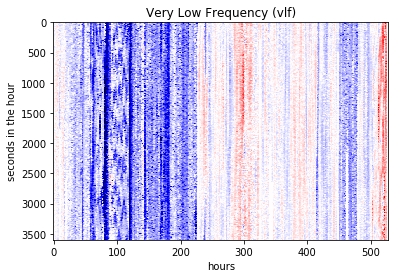

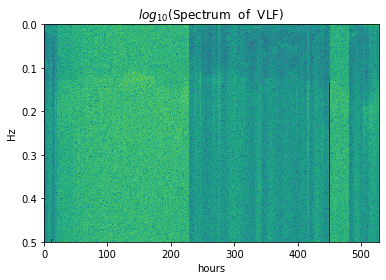

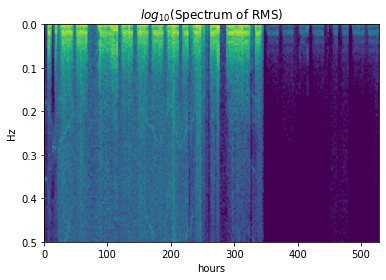

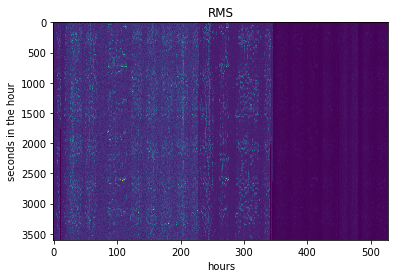

In [54]:
import matplotlib.pyplot as plt
import numpy
import scipy.signal as scs

# find the output directory from the 
configWITSMLIngest = os.path.join(CONFIG_DIR,'ingestWITSML_tfaConfig.json')
vlfConfig = json_read(configWITSMLIngest)
vlf_location = os.path.join(vlfConfig['out_drive'],vlfConfig['project'],vlfConfig['results'])
configWITSMLIngest = os.path.join(CONFIG_DIR,'ingestWITSML_rmsConfig.json')
rmsConfig = json_read(configWITSMLIngest)
rms_location = os.path.join(rmsConfig['out_drive'],rmsConfig['project'],rmsConfig['results'])


# NOTE: if you have changed the day you are processing, then the number of the file,
#       which is a unixtimestamp, will need to be changed. You can look in the result directory
#       to find the number
unixtimestamp_npy = '1580774400.npy'
tfa_tfa_location = os.path.join(data_location,'tfa','tfa',unixtimestamp_npy)
tfa_vlf_location = os.path.join(data_location,'tfa','vlf',unixtimestamp_npy)
rms_tfa_location = os.path.join(rms_location, 'tfa','tfa',unixtimestamp_npy)
rms_rms_location = os.path.join(rms_location, 'tfa','rms',unixtimestamp_npy)


# Read the data
data = numpy.load(tfa_tfa_location)
data2 = numpy.load(tfa_vlf_location)
data3 = numpy.load(rms_tfa_location)
data4 = numpy.load(rms_rms_location)

## Note - for the VLF data we showing the result as a saturated blue-white-red, with the saturation level set at
##        10% of maximum absolute value. This gives a good indication of the zero crossing (white) and the location
##        of reasonable positive (red) and negative (blue), but loses information about the true amplitude of the peaks and troughs
maxvlf = numpy.max(numpy.abs(data2))
maxvlf *= 0.1
data2 = scs.medfilt(data2,kernel_size=[9,3])
plt.imshow(data2, cmap='seismic', aspect='auto', vmin=-maxvlf, vmax=maxvlf)
plt.title('Very Low Frequency (vlf)')
plt.ylabel('seconds in the hour')
plt.xlabel('hours')
plt.show()

# The spectrum is symmetrical so we only plot half of it
npoints = int(data.shape[0]*0.5)
plt.imshow(numpy.log10(data[:npoints,:]+1.0), cmap='viridis', aspect='auto', extent=[0,data.shape[1],0.5,0])
plt.title('$log_{10}$(Spectrum  of  VLF)')
plt.ylabel('Hz')
plt.xlabel('hours')
plt.show()

# 2D median filter
data3 = scs.medfilt(data3[:int(data3.shape[0]*0.5),:],kernel_size=[9,3])
# threshold the data at 2 decades below the maximum
maxval = numpy.max(data3)
minval = numpy.log10(maxval)-2
data3[data3<numpy.power(10,minval)]=numpy.power(10,minval)
# plot log10(data)
plt.imshow(numpy.log10(data3[:int(data3.shape[0]*0.5),:]), cmap='viridis', aspect='auto', extent=[0,data.shape[1],0.5,0])
plt.title('$log_{10}$(Spectrum of RMS)')
plt.ylabel('Hz')
plt.xlabel('hours')
plt.show()


plt.imshow(data4, cmap='viridis', aspect='auto')
plt.title('RMS')
plt.ylabel('seconds in the hour')
plt.xlabel('hours')
plt.show()
